### Imports

In [4]:
%pip install ptflops


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
from __future__ import annotations
import random
from pathlib import Path
from typing import Tuple, Dict, List
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
from functools import partial
from bayes_opt import BayesianOptimization
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import (
    Compose, Resize, RandomHorizontalFlip,
    ToImage, ToDtype, Normalize
)
from ptflops import get_model_complexity_info
from torchvision.utils import make_grid

In [24]:
# -----------------------  constants  ---------------------------------
SEED               = 42
N_EPOCHS           = 40
BATCH_SIZE         = 128
IMAGE_SIZE         = (64, 64)            # Tiny‑ImageNet native size
LEARNING_RATE      = 0.002335
WEIGHT_DECAY       = 1e-5
MEAN        = [0.485, 0.456, 0.406]   # ImageNet stats
STD         = [0.229, 0.224, 0.225]
RUN_DIR            = Path("runs/tinyimagenet_cnn_vs_kan").resolve()
RUN_DIR.mkdir(parents=True, exist_ok=True)

random.seed(SEED)
torch.manual_seed(SEED)

device = (
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("mps")  if torch.backends.mps.is_available() else
    torch.device("cpu")
)
print(f"➡️  Using device: {device}")


➡️  Using device: mps


### Data Prep

In [25]:
def get_dataloaders(
    batch_size: int = BATCH_SIZE,
    image_size: Tuple[int, int] = IMAGE_SIZE
):
    # ── 1. load and split ──────────────────────────────────────────────
    ds       = load_dataset("zh-plus/tiny-imagenet", split=None)      # train / valid
    split    = ds["train"].train_test_split(
        test_size=0.10, seed=SEED, stratify_by_column="label"
    )
    train_ds = split["train"]           # 90 % → training
    val_ds   = split["test"]            # 10 % → internal val
    test_ds  = ds["valid"]              # official Tiny‑IN val → test set

    # ── 2. define transforms ───────────────────────────────────────────
    train_tfms = Compose([
        ToImage(),                              # PIL → tensor
        Resize(image_size, antialias=True),
        RandomHorizontalFlip(p=0.5),
        ToDtype(torch.float32, scale=True),     # convert + /255
        Normalize(MEAN, STD),
    ])
    eval_tfms = Compose([
        ToImage(),
        Resize(image_size, antialias=True),
        ToDtype(torch.float32, scale=True),
        Normalize(MEAN, STD),
    ])

    # wrap for HF set_transform (expects dict in, dict out)
    train_ds.set_transform(lambda ex: {
        "image": train_tfms(ex["image"]),
        "label": ex["label"],
    })
    for split_ds in (val_ds, test_ds):
        split_ds.set_transform(lambda ex: {
            "image": eval_tfms(ex["image"]),
            "label": ex["label"],
        })

    # ── 3. torch DataLoaders ───────────────────────────────────────────
    mk_loader = partial(
        DataLoader,
        batch_size=batch_size,
        pin_memory=True,
    )
    train_loader = mk_loader(train_ds, shuffle=True,  drop_last=True)
    val_loader   = mk_loader(val_ds,   shuffle=False, drop_last=False)
    test_loader  = mk_loader(test_ds,  shuffle=False, drop_last=False)

    return train_loader, val_loader, test_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


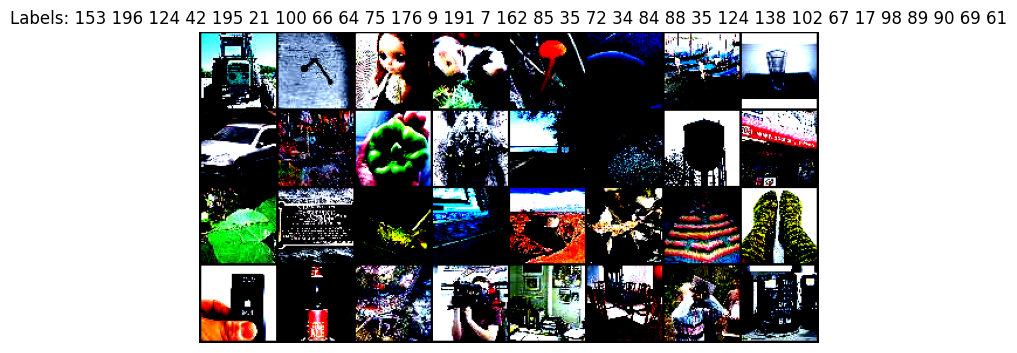

In [37]:

batch = next(iter(train_loader))
images  = batch["image"]                          # shape (B, 3, H, W)
labels  = batch["labels"] if "labels" in batch else batch["label"]

grid = make_grid(images[:32], nrow=8, padding=2)  # (3, H’, W’)

npimg = grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8, 8))
plt.imshow(npimg)
plt.axis("off")
plt.title("Labels: " + " ".join(str(x) for x in labels[:32].tolist()))
plt.show()

### Baseline CNN Architecture

In [8]:
class BaselineCNN(nn.Module):
    def __init__(self, n_classes: int = 200, dropout_p: float = 0.1):
        super().__init__()

        # ── Convolutional feature extractor ──────────────────────────────
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(2)  # 64→32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64→32
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16→8
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 8→4
        )
        # Global average pooling flattens to (B,512)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # ── Classifier head ──────────────────────────────────────────────
        self.ffn = nn.Sequential(
            nn.Linear(512, 384),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, n_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x).view(x.size(0), -1)  # flatten
        x = self.ffn(x)
        return x

### KAN-based CNN Architecture

In [9]:
from classes.BSplineActivation import BSplineActivation

class KANCNN(nn.Module):

    def __init__(self,
                 n_classes: int = 200,
                 input_shape=(3, 64, 64),
                 ch1: int = 64, ch2: int = 128, ch3: int = 256, ch4: int = 512,
                 kan_1: int = 512, kan_2: int = 384, kan_3: int = 200,
                 spline_cp: int = 7, spline_deg: int = 3,
                 range_min: float = -3.0, range_max: float = 70.0,
                 dropout_p: float = 0.1):
        super().__init__()
        C_in, *_ = input_shape

        # ── 1. Convolutional feature extractor (same as BaselineCNN) ──────
        self.conv1 = nn.Sequential(
            nn.Conv2d(C_in, ch1, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64→32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch1, ch2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32→16
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(ch2, ch3, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16→8
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(ch3, ch4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 8→4
        )
        self.gap = nn.AdaptiveAvgPool2d(1)  # 4×4 → 1×1

        # ── 2. KAN head ──────────────────────────────────────────────────
        flat_dim = ch4  # == 512 by default
        self.dropout = nn.Dropout(dropout_p)

        self.kan1 = nn.Linear(flat_dim, kan_1)
        self.kan1_act = BSplineActivation(spline_cp, spline_deg, range_min, range_max)

        self.kan2 = nn.Linear(kan_1, kan_2)
        self.kan2_act = BSplineActivation(spline_cp, spline_deg, range_min, range_max)

        self.kan3 = nn.Linear(kan_2, kan_3)
        self.kan3_act = BSplineActivation(spline_cp, spline_deg, range_min, range_max)

        # Optional: final classifier to logits (comment out if not needed)
        self.classifier = nn.Linear(kan_3, n_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    # ── 3. Forward pass ────────────────────────────────────────────────
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x).view(x.size(0), -1)
        x = self.dropout(x)

        x = self.kan1_act(self.kan1(x))
        x = self.kan2_act(self.kan2(x))
        x = self.kan3_act(self.kan3(x))
        x = self.dropout(x)

        logits = self.classifier(x)
        return logits


### Training Loop

In [10]:
# ---------------  training / eval helpers  ---------------------------
import json
import time


def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    return (logits.argmax(dim=1) == targets).float().mean()

def train_one_epoch(model: nn.Module, loader: DataLoader, criterion, optimizer, epoch: int) -> Dict[str, float]:
    model.train()
    loss_sum = acc_sum = 0.0
    for batch in tqdm(loader, desc=f"Train {epoch:02d}", leave=False):
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        acc = accuracy_from_logits(logits, y)
        loss_sum += loss.item() * x.size(0)
        acc_sum  += acc.item()  * x.size(0)

    n = len(loader.dataset)
    return {"loss": loss_sum / n, "acc": acc_sum / n}

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion) -> Dict[str, float]:
    model.eval()
    loss_sum = acc_sum = 0.0
    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        acc = accuracy_from_logits(logits, y)
        loss_sum += loss.item() * x.size(0)
        acc_sum  += acc.item() * x.size(0)
    n = len(loader.dataset)
    return {"loss": loss_sum / n, "acc": acc_sum / n}

def run_training(model:nn.Module, name:str,
                 train_loader:DataLoader, val_loader:DataLoader) -> Dict[str, List[float]]:
    """Full training loop for one model."""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

    for epoch in range(1, N_EPOCHS+1):
        tic = time.time()
        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
        val_metrics   = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_metrics["loss"])
        history["train_acc"].append(train_metrics["acc"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])

        print(f"Epoch {epoch:2d}/{N_EPOCHS} • "
              f"train acc {train_metrics['acc']*100:5.2f}% | "
              f"val acc {val_metrics['acc']*100:5.2f}% | "
              f"Δt {time.time()-tic:4.1f}s")

    torch.save(model.state_dict(), RUN_DIR/f"{name}.pt")
    with open(RUN_DIR/f"{name}_history.json", "w") as f:
        json.dump(history, f)
    return history

In [11]:
    

train_loader, val_loader, test_loader = get_dataloaders()

baseline = BaselineCNN()
kan      = KANCNN()


In [12]:
print("📚 Training baseline CNN …")
baseline_model = run_training(baseline, "baseline", train_loader, val_loader)

📚 Training baseline CNN …


Epoch  1/40 • train acc  5.28% | val acc  9.91% | Δt 189.8s


Epoch  2/40 • train acc 11.93% | val acc 13.69% | Δt 174.4s


Epoch  3/40 • train acc 15.91% | val acc 14.78% | Δt 173.0s


Epoch  4/40 • train acc 19.06% | val acc 19.53% | Δt 172.0s


Epoch  5/40 • train acc 21.59% | val acc 23.43% | Δt 174.0s


Epoch  6/40 • train acc 23.89% | val acc 26.55% | Δt 174.4s


Epoch  7/40 • train acc 26.13% | val acc 25.67% | Δt 173.4s


Epoch  8/40 • train acc 27.79% | val acc 29.15% | Δt 173.2s


Epoch  9/40 • train acc 30.05% | val acc 29.49% | Δt 169.8s


Epoch 10/40 • train acc 31.39% | val acc 31.43% | Δt 169.7s


Epoch 11/40 • train acc 33.10% | val acc 32.23% | Δt 169.8s


Epoch 12/40 • train acc 34.58% | val acc 31.24% | Δt 170.2s


Epoch 13/40 • train acc 36.06% | val acc 33.84% | Δt 171.6s


Epoch 14/40 • train acc 37.46% | val acc 34.13% | Δt 171.4s


Epoch 15/40 • train acc 38.86% | val acc 36.97% | Δt 171.6s


Epoch 16/40 • train acc 40.56% | val acc 36.27% | Δt 170.8s


Epoch 17/40 • train acc 41.58% | val acc 35.47% | Δt 170.4s


Epoch 18/40 • train acc 42.79% | val acc 37.42% | Δt 170.3s


Epoch 19/40 • train acc 44.21% | val acc 37.63% | Δt 170.3s


Epoch 20/40 • train acc 45.41% | val acc 38.38% | Δt 170.4s


Epoch 21/40 • train acc 46.75% | val acc 38.64% | Δt 170.3s


Epoch 22/40 • train acc 48.01% | val acc 38.83% | Δt 170.3s


Epoch 23/40 • train acc 49.02% | val acc 38.24% | Δt 170.2s


Epoch 24/40 • train acc 50.47% | val acc 38.57% | Δt 170.3s


Epoch 25/40 • train acc 51.62% | val acc 38.34% | Δt 170.3s


Epoch 26/40 • train acc 52.81% | val acc 38.29% | Δt 178.0s


Epoch 27/40 • train acc 54.01% | val acc 38.64% | Δt 279.4s


Epoch 28/40 • train acc 55.14% | val acc 38.60% | Δt 15665.3s


Epoch 29/40 • train acc 56.44% | val acc 38.08% | Δt 227.4s


Epoch 30/40 • train acc 57.34% | val acc 38.70% | Δt 168.3s


Epoch 31/40 • train acc 58.57% | val acc 38.57% | Δt 168.5s


Epoch 32/40 • train acc 59.67% | val acc 38.22% | Δt 181.9s


Epoch 33/40 • train acc 60.53% | val acc 39.10% | Δt 187.9s


Epoch 34/40 • train acc 61.90% | val acc 37.39% | Δt 187.4s


Epoch 35/40 • train acc 62.64% | val acc 37.48% | Δt 168.9s


Epoch 36/40 • train acc 63.64% | val acc 38.12% | Δt 168.6s


Epoch 37/40 • train acc 64.35% | val acc 38.08% | Δt 168.5s


Epoch 38/40 • train acc 65.25% | val acc 36.93% | Δt 168.4s


Epoch 39/40 • train acc 66.18% | val acc 36.13% | Δt 168.3s


Epoch 40/40 • train acc 66.74% | val acc 37.06% | Δt 168.4s


In [13]:
print("\n🌀 Training KAN‑CNN …")
hist_kan  = run_training(kan,      "KAN",      train_loader, val_loader)


🌀 Training KAN‑CNN …


Epoch  1/40 • train acc  2.70% | val acc  5.28% | Δt 50.8s


Epoch  2/40 • train acc  7.63% | val acc  9.52% | Δt 50.3s


Epoch  3/40 • train acc 11.29% | val acc 13.50% | Δt 50.3s


Epoch  4/40 • train acc 14.70% | val acc 15.35% | Δt 50.4s


Epoch  5/40 • train acc 17.79% | val acc 17.08% | Δt 50.4s


Epoch  6/40 • train acc 20.77% | val acc 20.90% | Δt 50.4s


Epoch  7/40 • train acc 22.99% | val acc 21.91% | Δt 50.5s


Epoch  8/40 • train acc 24.98% | val acc 21.76% | Δt 50.3s


Epoch  9/40 • train acc 27.35% | val acc 23.85% | Δt 50.4s


Epoch 10/40 • train acc 29.10% | val acc 27.90% | Δt 50.4s


Epoch 11/40 • train acc 31.31% | val acc 27.53% | Δt 50.5s


Epoch 12/40 • train acc 32.67% | val acc 30.50% | Δt 50.4s


Epoch 13/40 • train acc 34.74% | val acc 30.80% | Δt 50.4s


Epoch 14/40 • train acc 36.34% | val acc 30.77% | Δt 50.3s


Epoch 15/40 • train acc 37.67% | val acc 32.26% | Δt 50.5s


Epoch 16/40 • train acc 39.70% | val acc 32.36% | Δt 50.5s


Epoch 17/40 • train acc 41.32% | val acc 33.19% | Δt 50.4s


Epoch 18/40 • train acc 42.84% | val acc 33.57% | Δt 50.4s


Epoch 19/40 • train acc 44.50% | val acc 35.33% | Δt 50.4s


Epoch 20/40 • train acc 46.16% | val acc 33.46% | Δt 50.5s


Epoch 21/40 • train acc 47.57% | val acc 34.42% | Δt 50.4s


Epoch 22/40 • train acc 49.09% | val acc 36.61% | Δt 50.5s


Epoch 23/40 • train acc 50.91% | val acc 36.38% | Δt 50.4s


Epoch 24/40 • train acc 52.17% | val acc 35.61% | Δt 50.5s


Epoch 25/40 • train acc 53.81% | val acc 37.10% | Δt 50.5s


Epoch 26/40 • train acc 55.27% | val acc 36.27% | Δt 50.5s


Epoch 27/40 • train acc 56.52% | val acc 35.88% | Δt 50.5s


Epoch 28/40 • train acc 58.09% | val acc 37.30% | Δt 50.4s


Epoch 29/40 • train acc 59.37% | val acc 34.61% | Δt 50.5s


Epoch 30/40 • train acc 60.74% | val acc 36.39% | Δt 50.4s


Epoch 31/40 • train acc 61.85% | val acc 36.75% | Δt 50.5s


Epoch 32/40 • train acc 63.18% | val acc 36.72% | Δt 50.5s


Epoch 33/40 • train acc 64.29% | val acc 36.36% | Δt 50.5s


Epoch 34/40 • train acc 65.12% | val acc 36.88% | Δt 50.5s


Epoch 35/40 • train acc 66.49% | val acc 36.78% | Δt 50.5s


Epoch 36/40 • train acc 67.42% | val acc 37.39% | Δt 50.5s


Epoch 37/40 • train acc 68.34% | val acc 35.17% | Δt 50.5s


Epoch 38/40 • train acc 69.50% | val acc 36.10% | Δt 50.6s


Epoch 39/40 • train acc 70.51% | val acc 36.47% | Δt 50.4s


Epoch 40/40 • train acc 71.33% | val acc 36.63% | Δt 50.5s


In [14]:
criterion = nn.CrossEntropyLoss()
test_base = evaluate(baseline, test_loader, criterion)
test_kan  = evaluate(kan,      test_loader, criterion)


print(f"\n✅ Test accuracy: "
        f"Baseline {test_base['acc']*100:5.2f}% | "
        f"KAN {test_kan['acc']*100:5.2f}%")



✅ Test accuracy: Baseline 37.30% | KAN 36.67%


### Performance Metrics and Analysis

#### Plot

In [15]:
def plot_metrics(df:pd.DataFrame):
    """Plot accuracy + loss curves for both models."""
    sns.set_theme(style="whitegrid", font_scale=1.2)

    # Accuracy
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(df["epoch"], df["baseline_train_acc"], label="Baseline train")
    ax.plot(df["epoch"], df["baseline_val_acc"],   label="Baseline val")
    ax.plot(df["epoch"], df["kan_train_acc"],      label="KAN train", linestyle="--")
    ax.plot(df["epoch"], df["kan_val_acc"],        label="KAN val",   linestyle="--")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy (%)")
    ax.set_title("Tiny‑ImageNet • Accuracy vs. Epoch")
    ax.legend()
    fig.tight_layout()
    plt.savefig(RUN_DIR/"accuracy_curves.png", dpi=200)

    # Loss
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(df["epoch"], df["baseline_train_loss"], label="Baseline train")
    ax.plot(df["epoch"], df["baseline_val_loss"],   label="Baseline val")
    ax.plot(df["epoch"], df["kan_train_loss"],      label="KAN train", linestyle="--")
    ax.plot(df["epoch"], df["kan_val_loss"],        label="KAN val",   linestyle="--")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Cross‑entropy loss")
    ax.set_title("Tiny‑ImageNet • Loss vs. Epoch")
    ax.legend()
    fig.tight_layout()
    plt.savefig(RUN_DIR/"loss_curves.png", dpi=200)
    plt.show()

#### Metrics

In [21]:
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    total_size = param_size + buffer_size  # Bytes
    return total_size / (1024 * 1024)

def plot_confusion_matrix(model: nn.Module,
                          test_loader: DataLoader,
                          title='Confusion Matrix'):
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(100, 80))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def calculate_stats(model, input_shape=(3, 64, 64)):
    # Get model memory size
    model_size = get_model_size(model)
    
    # Get parameter count directly 
    param_count = count_parameters(model)
    
    # Get complexity info as raw numbers
    macs, params = get_model_complexity_info(
        model, 
        input_shape, 
        as_strings=False,  # Get raw numbers
        print_per_layer_stat=False,  
        verbose=False
    )
    
    # Convert to appropriate units
    macs_gflops = macs * 2 / 1e9  # Convert MACs to GFLOPs (1 MAC ≈ 2 FLOPs)
    params_m = param_count / 1e6   # Convert params to millions
    
    # Calculate inference time (optional)
    if hasattr(model, 'to') and torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        
    # Create a sample input
    sample_input = torch.randn(1, *input_shape).to(device)
    model = model.to(device).eval()
    
    # Warm-up
    with torch.no_grad():
        for _ in range(10):
            _ = model(sample_input)
    
    # Measure time
    if device.type == "cuda":
        torch.cuda.synchronize()
    elif device.type == "mps":
        torch.mps.synchronize()
        
    start_time = time.time()
    with torch.no_grad():
        for _ in range(100):
            _ = model(sample_input)
            
    if device.type == "cuda":
        torch.cuda.synchronize()
    elif device.type == "mps":
        torch.mps.synchronize()
        
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / 100 * 1000  # ms
    
    return model_size, macs_gflops, params_m, avg_inference_time
    
    
    
model_size, macs_gflops, params_m, avg_inference_time = calculate_stats(baseline)
print(f"""
      Model: {baseline}
      Size: {(model_size):.3f} MB
      Inference FLOPS: {macs_gflops:.2f}
      Number of parameters: {params_m:.2f} Million
      Avg Inference time: {avg_inference_time:.2f} ms
      """)


model_size, macs_gflops, params_m, avg_inference_time = calculate_stats(kan)
print(f"""
      Model: {kan}
      Size: {(model_size):.3f} MB
      Inference FLOPS: {macs_gflops:.2f}
      Number of parameters: {params_m:.2f} Million
      Avg Inference time: {avg_inference_time:.2f} ms
      """)


      Model: BaselineCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

### Optimize KAN

In [17]:
pbounds = {
    # ints → we pass floats in but will round later
    "epochs":             (20, 50),
    "kan_1":          (100, 512),   # width of first KAN layer
    "kan_2":          (100, 512),   # second KAN layer
    "kan_3":            (200, 200),
    "spline_cp":          (5, 10),      # control points
    "spline_deg":         (2, 4),      # deg ≤ cp‑1 guard enforced later
    "range_min":          (-2.0, -0.5),
    "range_max":          (40.0, 80.0),
    "lr":                 (1e-4, 1e-2)
}

import time
from tqdm.auto import tqdm

def train_kan(model, train_loader, val_loader, epochs, lr):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optim     = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

    best_val = 0.0
    for ep in range(1, epochs + 1):
        tic = time.time()
        # ─ train ─
        model.train()
        loss_sum = acc_sum = 0.0
        for batch in train_loader:
            x, y = batch["image"].to(device), batch["label"].to(device)
            optim.zero_grad(set_to_none=True)
            logits = model(x)
            loss   = criterion(logits, y)
            loss.backward()
            optim.step()

            acc = (logits.argmax(1) == y).float().mean().item()
            loss_sum += loss.item() * x.size(0)
            acc_sum  += acc * x.size(0)

        # ─ eval ─
        model.eval()
        loss_sum_val = acc_sum_val = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x, y = batch["image"].to(device), batch["label"].to(device)
                logits = model(x)
                loss   = criterion(logits, y)
                acc    = (logits.argmax(1) == y).float().mean().item()
                loss_sum_val += loss.item() * x.size(0)
                acc_sum_val  += acc * x.size(0)

        train_loss = loss_sum     / len(train_loader.dataset)
        train_acc  = acc_sum      / len(train_loader.dataset)
        val_loss   = loss_sum_val / len(val_loader.dataset)
        val_acc    = acc_sum_val  / len(val_loader.dataset)
        elapsed    = time.time() - tic

        # ← print exactly like you had it
        print(f"Epoch [{ep}/{epochs}], "
              f"Loss: {train_loss:.4f}, "
              f"Test Acc: {val_acc*100:5.2f}%, "
              f"Time: {elapsed:5.2f} seconds")

        best_val = max(best_val, val_acc)

    return best_val


def optimize_kan(epochs,
                 kan_1,
                 kan_2,
                 kan_3,
                 spline_cp,
                 spline_deg,
                 range_min,
                 range_max,
                 lr):

    # ─ cast + sanity ─
    epochs      = int(round(epochs))
    kan_1   = int(round(kan_1))
    kan_2   = int(round(kan_2))
    kan_3   = int(round(kan_3))
    spline_cp   = int(round(spline_cp))
    spline_deg  = int(round(spline_deg))

    # keep B‑spline well‑formed
    spline_deg  = max(2, min(spline_deg, spline_cp - 1))
    lr          = float(lr)

    model = KANCNN(
        kan_1=kan_1,
        kan_2=kan_2,
        kan_3=kan_3,
        spline_cp=spline_cp,
        spline_deg=spline_deg,
        range_min=range_min,
        range_max=range_max
    )

    val_acc = train_kan(model, train_loader, val_loader, epochs, lr)

    # BayesOpt maximizes the returned value
    return val_acc



In [18]:



optimizer = BayesianOptimization(
    f=optimize_kan,
    pbounds=pbounds,
    random_state=38,
    verbose=2
)

optimizer.maximize(init_points=2, n_iter=20)

print("🚀 best combo so far →", optimizer.max)

|   iter    |  target   |  epochs   |   kan_1   |   kan_2   |   kan_3   |    lr     | range_max | range_min | spline_cp | spline... |
-------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/32], Loss: 4.8680, Test Acc:  4.82%, Time: 50.94 seconds
Epoch [2/32], Loss: 4.2893, Test Acc:  9.60%, Time: 50.68 seconds
Epoch [3/32], Loss: 3.9140, Test Acc: 14.48%, Time: 50.62 seconds
Epoch [4/32], Loss: 3.6421, Test Acc: 17.55%, Time: 50.62 seconds
Epoch [5/32], Loss: 3.4288, Test Acc: 21.77%, Time: 51.21 seconds
Epoch [6/32], Loss: 3.2510, Test Acc: 24.26%, Time: 50.56 seconds
Epoch [7/32], Loss: 3.0785, Test Acc: 26.97%, Time: 50.64 seconds
Epoch [8/32], Loss: 2.9246, Test Acc: 27.78%, Time: 50.63 seconds
Epoch [9/32], Loss: 2.7833, Test Acc: 31.44%, Time: 50.69 seconds
Epoch [10/32], Loss: 2.6488, Test Acc: 30.69%, Time: 50.63 seconds
Epoch [11/32], Loss: 2.5324, Test Acc: 34.06%, Time: 50.61 seconds
Epoc

KeyboardInterrupt: 